#**🎙️Emotion Classification from Speech**

This project focuses on building a robust pipeline to classify human emotions based on speech audio data using deep learning techniques. It includes audio preprocessing, feature extraction, model training, evaluation, and deployment through a web interface.

##**🔍 Objective**


To design and implement a robust pipeline for emotion classification from speech data using audio processing and deep learning models.

##**🎯 Evaluation Criteria**

- F1-score ≥ 80%
- Per-class accuracy ≥ 75%
- Overall accuracy ≥ 80%
- Performance verified on a hidden test set

In [ ]:
#Load dataset
data_folders = ['/content/drive/MyDrive/Audio_Speech_Actors_01-24', '/content/drive/MyDrive/Audio_Song_Actors_01-24']


In [ ]:
# LIBERARIES
import os
import numpy as np
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import warnings

In [ ]:
# Defining Feature function

import os
import numpy as np
import librosa

emotion_dict = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

def extract_emotion_label(filename):
    return emotion_dict.get(filename.split("-")[2], None)

def extract_features_mfcc(audio, sr, n_mfcc=40, max_len=300):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc.T

def add_noise(data, noise_factor=0.005):
    noise = np.random.randn(len(data))
    return data + noise_factor * noise

def pitch_shift(data, sr, n_steps=2):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

data_folders = [
    r'C:\Users\Lenovo\Downloads\SER\Audio_Song_Actors_01-24',
    r'C:\Users\Lenovo\Downloads\SER\Audio_Speech_Actors_01-24'
]

samples = []

for folder in data_folders:
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith('.wav'):
                label = extract_emotion_label(file)
                if label:
                    samples.append((os.path.join(root, file), label))

print(f"✅ Total samples: {len(samples)}")


✅ Total samples: 2452


##**Visualize Waveform, Spectrogram, MFCCs**

✅ Total samples: 2452


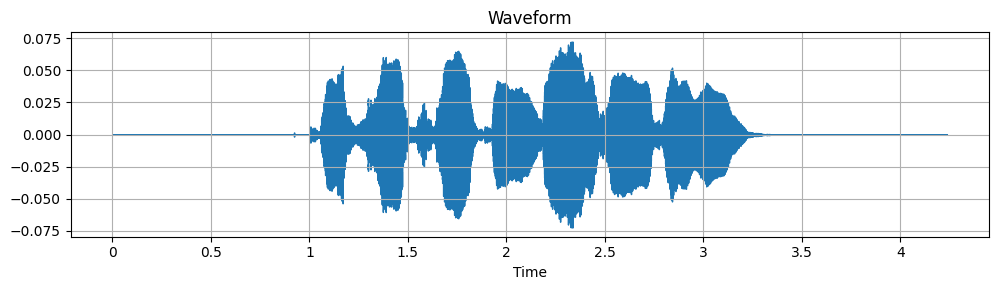

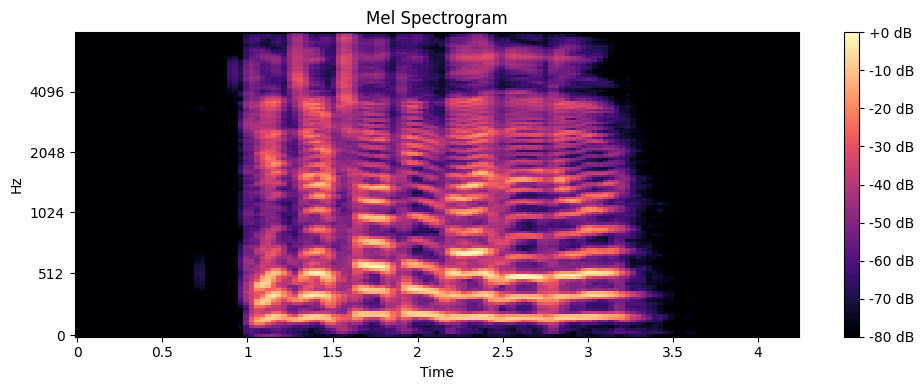

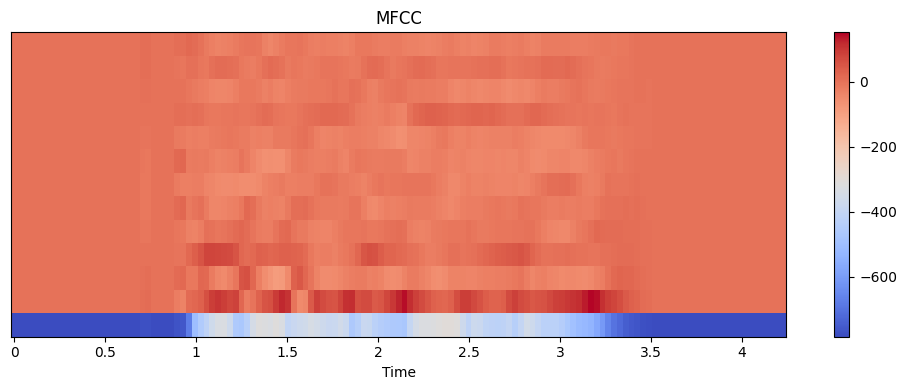

In [ ]:
#Spectrogram, MFCCs and waveform

import os
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Define emotion labels
emotion_dict = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# Function to extract emotion label from filename
def extract_emotion_label(filename):
    return emotion_dict.get(filename.split("-")[2], None)

# Folder paths
data_folders = [
    r'C:\Users\Lenovo\Downloads\SER\Audio_Song_Actors_01-24',
    r'C:\Users\Lenovo\Downloads\SER\Audio_Speech_Actors_01-24'
]

# Create DataFrame
filepaths = []
labels = []

for folder in data_folders:
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith('.wav'):
                label = extract_emotion_label(file)
                if label:
                    filepaths.append(os.path.join(root, file))
                    labels.append(label)

# Build the DataFrame
df = pd.DataFrame({'filepath': filepaths, 'emotion': labels})
print(f"✅ Total samples: {len(df)}")

# --- Visualization ---
# Pick the first sample
sample_path = df['filepath'].iloc[0]
y, sr = librosa.load(sample_path, sr=16000)

# Waveform
plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time')
plt.grid()
plt.tight_layout()
plt.show()

# Mel Spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

# MFCCs
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()


In [ ]:
#preprocessing dataset for training

filepaths, labels = zip(*samples)
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    filepaths, labels_encoded, stratify=labels_encoded, test_size=0.2, random_state=42
)
def process_files(filepaths, labels, augment=False):
    X, y = [], []
    for path, label in zip(filepaths, labels):
        try:
            audio, sr = librosa.load(path, sr=None)

           
            features = extract_features_mfcc(audio, sr)
            X.append(features)
            y.append(label)

            if augment:
           
                noise_audio = add_noise(audio)
                features = extract_features_mfcc(noise_audio, sr)
                X.append(features)
                y.append(label)

              
                pitch_audio = pitch_shift(audio, sr)
                features = extract_features_mfcc(pitch_audio, sr)
                X.append(features)
                y.append(label)

        except Exception as e:
            print(f"Error processing {path}: {e}")
    return np.array(X), np.array(y)

X_train, y_train = process_files(train_paths, train_labels, augment=True)
X_val, y_val = process_files(val_paths, val_labels, augment=False)


In [ ]:
!pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE
X_train_flat = X_train.reshape(X_train.shape[0], -1)
smote = SMOTE(random_state=42)
X_train_flat, y_train = smote.fit_resample(X_train_flat, y_train)
X_train = X_train_flat.reshape(-1, X_train.shape[1], X_train.shape[2])
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))


In [ ]:
#Model training- CNN - LSTM

model = Sequential([
    Conv1D(128, 5, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(256, 5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Bidirectional(LSTM(128, return_sequences=False)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(classes), activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_val, y_val),
                    class_weight=class_weight_dict,
                    callbacks=[checkpoint, reduce_lr])


Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.1392 - loss: 2.9438

226/226 ━━━━━━━━━━━━━━━━━━━━ 140s 575ms/step - accuracy: 0.1393 - loss: 2.9433 - val_accuracy: 0.2811 - val_loss: 1.8548 - learning_rate: 1.0000e-04
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.1789 - loss: 2.5653

226/226 ━━━━━━━━━━━━━━━━━━━━ 142s 576ms/step - accuracy: 0.1789 - loss: 2.5649 - val_accuracy: 0.3014 - val_loss: 1.7607 - learning_rate: 1.0000e-04
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.2204 - loss: 2.3221

226/226 ━━━━━━━━━━━━━━━━━━━━ 138s 562ms/step - accuracy: 0.2204 - loss: 2.3221 - val_accuracy: 0.3279 - val_loss: 1.7335 - learning_rate: 1.0000e-04
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.2430 - loss: 2.2000

226/226 ━━━━━━━━━━━━━━━━━━━━ 147s 581ms/step - accuracy: 0.2430 - loss: 2.1999 - val_accuracy: 0.3340 - val_loss: 1.6595 - learning_rate: 1.0000e-04
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.2755 - loss: 2.0789

226/226 ━━━━━━━━━━━━━━━━━━━━ 125s 555ms/step - accuracy: 0.2755 - loss: 2.0787 - val_accuracy: 0.3666 - val_loss: 1.6472 - learning_rate: 1.0000e-04
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 558ms/step - accuracy: 0.3065 - loss: 1.9372

226/226 ━━━━━━━━━━━━━━━━━━━━ 145s 567ms/step - accuracy: 0.3065 - loss: 1.9372 - val_accuracy: 0.4073 - val_loss: 1.5873 - learning_rate: 1.0000e-04
Epoch 7/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.3326 - loss: 1.8587

226/226 ━━━━━━━━━━━━━━━━━━━━ 133s 589ms/step - accuracy: 0.3326 - loss: 1.8586 - val_accuracy: 0.4114 - val_loss: 1.5121 - learning_rate: 1.0000e-04
Epoch 8/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.3478 - loss: 1.8030

226/226 ━━━━━━━━━━━━━━━━━━━━ 130s 573ms/step - accuracy: 0.3478 - loss: 1.8030 - val_accuracy: 0.4236 - val_loss: 1.5003 - learning_rate: 1.0000e-04
Epoch 9/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.3746 - loss: 1.7386

226/226 ━━━━━━━━━━━━━━━━━━━━ 145s 590ms/step - accuracy: 0.3745 - loss: 1.7385 - val_accuracy: 0.4257 - val_loss: 1.4515 - learning_rate: 1.0000e-04
Epoch 10/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 142s 589ms/step - accuracy: 0.3739 - loss: 1.7115 - val_accuracy: 0.4338 - val_loss: 1.4518 - learning_rate: 1.0000e-04
Epoch 11/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.4022 - loss: 1.6174

226/226 ━━━━━━━━━━━━━━━━━━━━ 150s 622ms/step - accuracy: 0.4022 - loss: 1.6175 - val_accuracy: 0.4664 - val_loss: 1.3868 - learning_rate: 1.0000e-04
Epoch 12/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.4115 - loss: 1.6013

226/226 ━━━━━━━━━━━━━━━━━━━━ 134s 587ms/step - accuracy: 0.4115 - loss: 1.6012 - val_accuracy: 0.4827 - val_loss: 1.3577 - learning_rate: 1.0000e-04
Epoch 13/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.4277 - loss: 1.5477

226/226 ━━━━━━━━━━━━━━━━━━━━ 136s 601ms/step - accuracy: 0.4277 - loss: 1.5476 - val_accuracy: 0.4888 - val_loss: 1.3538 - learning_rate: 1.0000e-04
Epoch 14/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.4472 - loss: 1.4962

226/226 ━━━━━━━━━━━━━━━━━━━━ 133s 590ms/step - accuracy: 0.4472 - loss: 1.4961 - val_accuracy: 0.4949 - val_loss: 1.3083 - learning_rate: 1.0000e-04
Epoch 15/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 146s 607ms/step - accuracy: 0.4599 - loss: 1.4271 - val_accuracy: 0.5153 - val_loss: 1.3154 - learning_rate: 1.0000e-04
Epoch 16/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - accuracy: 0.4975 - loss: 1.3676

226/226 ━━━━━━━━━━━━━━━━━━━━ 143s 614ms/step - accuracy: 0.4975 - loss: 1.3676 - val_accuracy: 0.5153 - val_loss: 1.2850 - learning_rate: 1.0000e-04
Epoch 17/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.5133 - loss: 1.3154

226/226 ━━━━━━━━━━━━━━━━━━━━ 136s 585ms/step - accuracy: 0.5133 - loss: 1.3154 - val_accuracy: 0.5601 - val_loss: 1.1995 - learning_rate: 1.0000e-04
Epoch 18/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 155s 646ms/step - accuracy: 0.5295 - loss: 1.2638 - val_accuracy: 0.5560 - val_loss: 1.2123 - learning_rate: 1.0000e-04
Epoch 19/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.5530 - loss: 1.2239

226/226 ━━━━━━━━━━━━━━━━━━━━ 189s 587ms/step - accuracy: 0.5531 - loss: 1.2238 - val_accuracy: 0.5540 - val_loss: 1.1933 - learning_rate: 1.0000e-04
Epoch 20/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.5654 - loss: 1.1691

226/226 ━━━━━━━━━━━━━━━━━━━━ 133s 591ms/step - accuracy: 0.5654 - loss: 1.1692 - val_accuracy: 0.6008 - val_loss: 1.0707 - learning_rate: 1.0000e-04
Epoch 21/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 149s 622ms/step - accuracy: 0.5879 - loss: 1.1125 - val_accuracy: 0.5784 - val_loss: 1.1212 - learning_rate: 1.0000e-04
Epoch 22/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.6172 - loss: 1.0480

226/226 ━━━━━━━━━━━━━━━━━━━━ 143s 634ms/step - accuracy: 0.6171 - loss: 1.0481 - val_accuracy: 0.5906 - val_loss: 1.0297 - learning_rate: 1.0000e-04
Epoch 23/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.6169 - loss: 1.0485

226/226 ━━━━━━━━━━━━━━━━━━━━ 197s 609ms/step - accuracy: 0.6170 - loss: 1.0483 - val_accuracy: 0.6395 - val_loss: 0.9836 - learning_rate: 1.0000e-04
Epoch 24/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 139s 598ms/step - accuracy: 0.6472 - loss: 0.9656 - val_accuracy: 0.6029 - val_loss: 1.0923 - learning_rate: 1.0000e-04
Epoch 25/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.6623 - loss: 0.9446

226/226 ━━━━━━━━━━━━━━━━━━━━ 143s 602ms/step - accuracy: 0.6623 - loss: 0.9446 - val_accuracy: 0.6578 - val_loss: 0.9404 - learning_rate: 1.0000e-04
Epoch 26/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 137s 583ms/step - accuracy: 0.6701 - loss: 0.9144 - val_accuracy: 0.6558 - val_loss: 0.9739 - learning_rate: 1.0000e-04
Epoch 27/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 133s 589ms/step - accuracy: 0.6740 - loss: 0.9039 - val_accuracy: 0.6843 - val_loss: 0.9531 - learning_rate: 1.0000e-04
Epoch 28/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.6915 - loss: 0.8484

226/226 ━━━━━━━━━━━━━━━━━━━━ 146s 605ms/step - accuracy: 0.6915 - loss: 0.8484 - val_accuracy: 0.6884 - val_loss: 0.9020 - learning_rate: 1.0000e-04
Epoch 29/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.6964 - loss: 0.8271

226/226 ━━━━━━━━━━━━━━━━━━━━ 147s 628ms/step - accuracy: 0.6964 - loss: 0.8270 - val_accuracy: 0.7047 - val_loss: 0.8779 - learning_rate: 1.0000e-04
Epoch 30/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.7231 - loss: 0.7819

226/226 ━━━━━━━━━━━━━━━━━━━━ 199s 615ms/step - accuracy: 0.7231 - loss: 0.7819 - val_accuracy: 0.7047 - val_loss: 0.8050 - learning_rate: 1.0000e-04
Epoch 31/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.7391 - loss: 0.7510

226/226 ━━━━━━━━━━━━━━━━━━━━ 135s 586ms/step - accuracy: 0.7391 - loss: 0.7510 - val_accuracy: 0.7332 - val_loss: 0.7808 - learning_rate: 1.0000e-04
Epoch 32/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 581ms/step - accuracy: 0.7363 - loss: 0.7272

226/226 ━━━━━━━━━━━━━━━━━━━━ 146s 605ms/step - accuracy: 0.7363 - loss: 0.7272 - val_accuracy: 0.7169 - val_loss: 0.7731 - learning_rate: 1.0000e-04
Epoch 33/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 135s 599ms/step - accuracy: 0.7488 - loss: 0.7349 - val_accuracy: 0.7230 - val_loss: 0.8285 - learning_rate: 1.0000e-04
Epoch 34/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 138s 579ms/step - accuracy: 0.7618 - loss: 0.6670 - val_accuracy: 0.7108 - val_loss: 0.8377 - learning_rate: 1.0000e-04
Epoch 35/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.7668 - loss: 0.6523

226/226 ━━━━━━━━━━━━━━━━━━━━ 140s 571ms/step - accuracy: 0.7668 - loss: 0.6523 - val_accuracy: 0.7515 - val_loss: 0.7570 - learning_rate: 1.0000e-04
Epoch 36/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 142s 571ms/step - accuracy: 0.7792 - loss: 0.6249 - val_accuracy: 0.7108 - val_loss: 0.8591 - learning_rate: 1.0000e-04
Epoch 37/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.7923 - loss: 0.5904

226/226 ━━━━━━━━━━━━━━━━━━━━ 145s 584ms/step - accuracy: 0.7922 - loss: 0.5905 - val_accuracy: 0.7495 - val_loss: 0.7431 - learning_rate: 1.0000e-04
Epoch 38/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 145s 598ms/step - accuracy: 0.7902 - loss: 0.5949 - val_accuracy: 0.7495 - val_loss: 0.7712 - learning_rate: 1.0000e-04
Epoch 39/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 138s 582ms/step - accuracy: 0.8114 - loss: 0.5610 - val_accuracy: 0.7373 - val_loss: 0.8470 - learning_rate: 1.0000e-04
Epoch 40/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - accuracy: 0.8135 - loss: 0.5448

226/226 ━━━━━━━━━━━━━━━━━━━━ 138s 562ms/step - accuracy: 0.8135 - loss: 0.5448 - val_accuracy: 0.7699 - val_loss: 0.7422 - learning_rate: 1.0000e-04
Epoch 41/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 152s 606ms/step - accuracy: 0.8075 - loss: 0.5563 - val_accuracy: 0.7576 - val_loss: 0.7633 - learning_rate: 1.0000e-04
Epoch 42/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 139s 615ms/step - accuracy: 0.8296 - loss: 0.4909 - val_accuracy: 0.7597 - val_loss: 0.7928 - learning_rate: 1.0000e-04
Epoch 43/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.8288 - loss: 0.4923

226/226 ━━━━━━━━━━━━━━━━━━━━ 131s 578ms/step - accuracy: 0.8288 - loss: 0.4924 - val_accuracy: 0.8086 - val_loss: 0.6760 - learning_rate: 1.0000e-04
Epoch 44/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 130s 577ms/step - accuracy: 0.8439 - loss: 0.4659 - val_accuracy: 0.7434 - val_loss: 0.8851 - learning_rate: 1.0000e-04
Epoch 45/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 144s 585ms/step - accuracy: 0.8354 - loss: 0.4868 - val_accuracy: 0.7597 - val_loss: 0.7633 - learning_rate: 1.0000e-04
Epoch 46/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 138s 567ms/step - accuracy: 0.8402 - loss: 0.4698 - val_accuracy: 0.7821 - val_loss: 0.6849 - learning_rate: 1.0000e-04
Epoch 47/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 142s 569ms/step - accuracy: 0.8562 - loss: 0.4195 - val_accuracy: 0.7902 - val_loss: 0.7336 - learning_rate: 5.0000e-05
Epoch 48/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 130s 574ms/step - accuracy: 0.8639 - loss: 0.3988 - val_accuracy: 0.7739 - val_loss: 0.7721 - learning_rate: 5.0000e-05
Epoch 49/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 132s 

226/226 ━━━━━━━━━━━━━━━━━━━━ 142s 585ms/step - accuracy: 0.8763 - loss: 0.3584 - val_accuracy: 0.8106 - val_loss: 0.6704 - learning_rate: 2.5000e-05


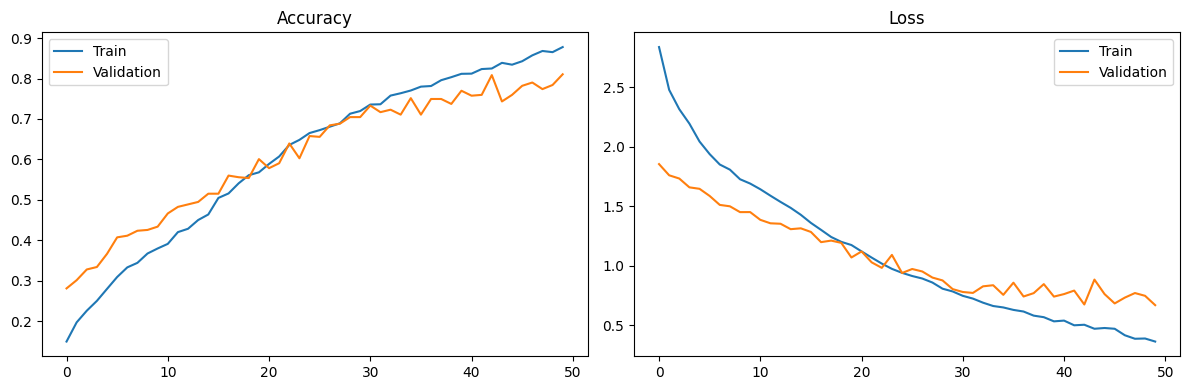

In [ ]:
#evaluation - loss, accuracy graphs

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step
              precision    recall  f1-score   support

       angry       0.90      0.85      0.88        75
        calm       0.89      0.83      0.86        75
     disgust       0.79      0.79      0.79        39
     fearful       0.83      0.73      0.78        75
       happy       0.97      0.77      0.86        75
     neutral       0.68      0.95      0.79        38
         sad       0.70      0.75      0.72        75
   surprised       0.69      0.92      0.79        39

    accuracy                           0.81       491
   macro avg       0.81      0.82      0.81       491
weighted avg       0.83      0.81      0.81       491



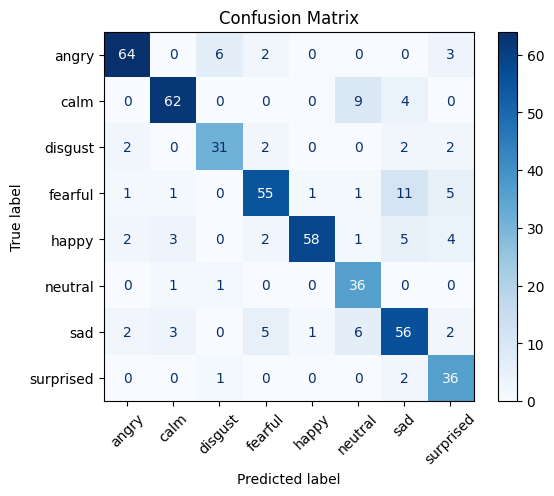

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_val, y_pred_classes, target_names=le.classes_))
cm = confusion_matrix(y_val, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()